# Big project activity

## Optimal charging station location

### 1.Introduction

Consider a long linear cycle path as Vento, or the Danube cycle path. The cycle path usually runs along the banks of a river with scarce tourist interest. However, from the main course of the cycle path, it is possible to reach places of tourist interest in making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non-negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. Moreover, the presence of a charging station could also induce e-cyclists to discover new places and generate positive externalities.



### 2.Decision problem
We can represent the cycle path as a graph where the set of nodes $H = \{1,\ldots, n\}$ corresponds to the tourist sites that may host a charging station.
In addition, we are given the distances between touristic sites ($d_{ij},$ with $ i,j =1,\ldots,n$). Let $c_i$ be the cost of installing a charging station in site $i, i=1\ldots, n$.


The problem is, given a budget $b$, determine the subset of sites $S\subseteq H$ where to install the charging stations so that the total cost is not higher than $b$ and the maximum distance between consecutive charging stations is minimized.
Consider that the cyclist has to visit all the touristic destinations in a consecutive way.



### 3.Problem characteristics
There are 2 csv files that contain the information of the cycle way, they are essential to build the equivalent graph:


*    in the "nodes.csv" file, there are all the destinations that the cyclist can reach, with their spatial coordinates and the value of installation costs related to that destination. Consider that the "tourist-dest-id" is not the graph node number, but it is a unique id to identify the destination.
*   in the "OD.csv" you can find all the arcs between two different nodes, keep attention that the condition of visiting consecutive touristic destination must be respected.

The set of nodes $N$ is defined by $\{0,1,\ldots,n, n+1\}$.  The Arcs $A$ correspond to the portion of cycle path between two consecutive charging stations. We assume that potentially e-riders will visit all sites along the way, making the suitable deviations and going back to the main path at the initial point of the detour.
The cost associated with each arc $(i,j)$ is given by $c_j$, thus the cost of installing a charging station in $j$. These costs are defined for all arcs in $A$, while they are set to 0 for all the arcs that arrive in the last node.
The path starts in node $s = 0$ and ends in node $t = n+1$, these two nodes are connected to the nearest touristic site with an arc of null length.

### 4.Example of a linear path with deviation
![picture](https://drive.google.com/uc?export=view&id=1w16bHtbu0FGGL-UntxeqxD7244D3eHbJ)

### 5.Requirements
The requirements of the problem are:


*   the maximum running time of the algorithm must be 5 minutes, so set the proper timer
*   create the equivalent graph and display it on a xy-plot
*   find the solution for the basic scenario, with a mip model, displaying the solution with a xy-plot, the budget constraint is $b = 10000\ € $.
*   Find the optimal solution for 5 different values of budget in the range $[10000, 100000]$. Select the values of the budget so as to have different charger locations.

  You have to motivate your choice and the solution you get. They can also be not common solution if they are well motivated. To support your decision and explanations, you can print plots or tables. You can also compare different scenarios.


   
If you have some doubts related to the parametric analysis, prof. Cubillos uploaded a notebook with the solution on WeBeeP and you can have a look there.

### Insert student name and student ID

student1: Lorenzo Battiston

ID1: 10618906

student2:

ID2:


In [1]:
#install libraries
!pip install mip
!pip install --upgrade cffi==1.15.0
!pip install pyCombinatorial
!pip install -U prettytable

In [2]:
#import libraries
import importlib
import cffi

importlib.reload(cffi)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import folium
import datetime
from branca.element import Figure
from prettytable import PrettyTable
from pyCombinatorial.algorithm import ant_colony_optimization
from pyCombinatorial.utils import util
import mip
from mip import OptimizationStatus

In [3]:
# set the budget
budget: int = 10_000
print(f"Budget: {budget:,.2f} €")

max_distance = 50_000  # 50,000 meters
print(f"Max Distance: {max_distance:,.0f} m")

Budget: 10,000.00 €
Max Distance: 50,000 m


In [4]:
starting_time = datetime.datetime.now()

# Import
In this cell, we are loading the nodes data from a CSV file, which includes information about various touristic sites. The data is loaded into a pandas DataFrame for easy manipulation and analysis. We also perform initial data cleaning and map the node IDs in order to have an enumeration of IDs, ensuring consistency across our datasets.


In [5]:
# Load nodes data from CSV

nodes_data: pd.DataFrame = pd.read_csv('nodes.csv', encoding='unicode_escape')

# Display information about candidate touristic sites and nodes
num_nodes: int = len(nodes_data) + 2
print(f"Number of candidate touristic sites: {len(nodes_data)}")
print(f"Number of Nodes (including source and sink): {num_nodes}")

# Load OD data from CSV and map node IDs
od_data: pd.DataFrame = pd.read_csv('OD.csv')
node_id_mapping: dict[int, int] = {node_id: i for i, node_id in enumerate(nodes_data['tourist_dest_id'])}
od_data[['origin_id', 'destination_id']] = od_data[['origin_id', 'destination_id']].apply(
    lambda x: x.map(node_id_mapping))

# Data Cleaning
od_data['distance [m]'].fillna(0, inplace=True)
od_data[['origin_id', 'destination_id']] = od_data[['origin_id', 'destination_id']].astype(int)

# Map node IDs in nodes_data
nodes_data['tourist_dest_id'] = nodes_data['tourist_dest_id'].map(node_id_mapping)

# Display the number of arcs and the node ID mapping
print(f"Number of arcs: {len(od_data)}")
print(f"Node ID Mapping: {node_id_mapping}")

Number of candidate touristic sites: 44
Number of Nodes (including source and sink): 46
Number of arcs: 1936
Node ID Mapping: {0: 0, 17: 1, 18: 2, 20: 3, 21: 4, 23: 5, 24: 6, 25: 7, 29: 8, 30: 9, 31: 10, 32: 11, 33: 12, 35: 13, 36: 14, 38: 15, 39: 16, 40: 17, 41: 18, 48: 19, 52: 20, 53: 21, 54: 22, 57: 23, 58: 24, 60: 25, 61: 26, 62: 27, 63: 28, 64: 29, 66: 30, 67: 31, 68: 32, 69: 33, 77: 34, 82: 35, 83: 36, 84: 37, 85: 38, 86: 39, 87: 40, 88: 41, 89: 42, 90: 43}


# Utility Functions

In [6]:
def find_id(mapping, value):
    return next((k for k, v in mapping.items() if v == value), None)


def rearrange_list(original_list, target_value):
    try:
        # Find the index of the target value
        index_of_target = original_list.index(target_value)

        # Create a new list with items after the target value
        items_after_target = original_list[index_of_target + 1:]

        # Create another list with items before the target value from start, excluding the first one
        items_before_target = original_list[:index_of_target][1:]

        # Combine the two lists in the desired order
        result_list = items_after_target + items_before_target

        return result_list

    except ValueError:
        # Handle the case when the target value is not in the original list
        print(f"{target_value} not found in the original list.")
        return None


def decrease_list_length(lst):
    return [element - 1 for element in lst]


def calculate_total_distance(ordered_path, distance_matrix):
    return sum(distance_matrix[ordered_path[i], ordered_path[i + 1]] for i in range(len(ordered_path) - 1))


def find_first_node(nodes_data: pd.DataFrame) -> int:
    """
    Finds the first node based on the lowest value of longitude.

    Parameters:
    - nodes_data (pd.DataFrame): DataFrame containing node data with 'tourist_dest_id', 'x (longitude)', 'y (latitude)', etc.

    Returns:
    - int: The tourist destination ID of the node with the lowest longitude.
    """
    min_longitude_row = nodes_data.loc[nodes_data['x (longitude)'].idxmin()]
    return min_longitude_row['tourist_dest_id']


def find_last_node(nodes_data: pd.DataFrame) -> int:
    """
    Finds the last node based on the highest value of longitude.

    Parameters:
    - nodes_data (pd.DataFrame): DataFrame containing node data with 'tourist_dest_id', 'x (longitude)', 'y (latitude)', etc.

    Returns:
    - int: The tourist destination ID of the node with the highest longitude.
    """
    max_longitude_row = nodes_data.loc[nodes_data['x (longitude)'].idxmax()]
    return max_longitude_row['tourist_dest_id']


# Function to calculate the distance between two nodes
def nodes_distance(node1: int, node2: int, ordered_path, distance_matrix) -> float:
    """
    Calculates the distance between two nodes.

    Parameters:
    - node1 (int): The ID of the first node.
    - node2 (int): The ID of the second node.

    Returns:
    - float: The distance between the two nodes.
    """
    index1 = ordered_path.index(node1)
    index2 = ordered_path.index(node2)
    return sum(distance_matrix[ordered_path[i], ordered_path[i+1]] for i in range(index1, index2))

def find_valid_arcs(ordered_path, distance_matrix, max_distance):
    valid_arcs = {}

    for i, start_node in enumerate(ordered_path):
        for next_node in ordered_path[i + 1:]:
            distance = nodes_distance(start_node, next_node, ordered_path, distance_matrix)
            if(distance <= max_distance):
                valid_arcs[(start_node, next_node)] = distance
            else: break
    return valid_arcs

In [7]:
def create_distance_matrix(data):
    """
    Create a distance matrix based on origin-destination data.

    Parameters:
    - data: DataFrame containing origin-destination data with 'origin_id', 'destination_id', and 'distance [m]'

    Returns:
    - NumPy array representing the distance matrix
    """

    max_origin, max_dest = data['origin_id'].max(), data['destination_id'].max()
    distance_matrix = np.zeros((max_origin + 1, max_dest + 1), dtype=float)

    for _, row in data.iterrows():
        i, j = int(row['origin_id']), int(row['destination_id'])
        distance_matrix[i, j] = row['distance [m]']

    return distance_matrix


distance_matrix = create_distance_matrix(od_data)

print(distance_matrix)

[[    0.       43798.0845   47252.99168  ... 29952.03933  29218.36919
  16011.18979 ]
 [43798.0845       0.        7024.78491  ... 14536.5039   18144.20219
  28400.97779 ]
 [47252.99168   7024.78491      0.       ... 17991.41108  21599.10937
  31855.88497 ]
 ...
 [29952.03933  14536.5039   17991.41108  ...     0.        4298.157018
  14554.93262 ]
 [29218.36919  18144.20219  21599.10937  ...  4298.157018     0.
  13821.26248 ]
 [16011.18979  28400.97779  31855.88497  ... 14554.93262  13821.26248
      0.      ]]


In [8]:
def add_dummy_node(distance_matrix):
    """
    Add a dummy node with distance 0 to all other nodes in the distance matrix.

    Parameters:
    - distance_matrix: NumPy array representing the distance matrix

    Returns:
    - NumPy array representing the distance matrix with the dummy node
    """

    max_origin, max_dest = distance_matrix.shape[0] - 1, distance_matrix.shape[1] - 1
    dummy_node_index = max(max_origin, max_dest) + 1

    # Create a new matrix with the dummy node
    distance_matrix_with_dummy = np.zeros((dummy_node_index + 1, dummy_node_index + 1), dtype=float)

    # Copy existing distances to the new matrix
    distance_matrix_with_dummy[:max_origin + 1, :max_dest + 1] = distance_matrix

    # Set distances from the dummy node to all other nodes to 0
    distance_matrix_with_dummy[dummy_node_index, :] = 0
    distance_matrix_with_dummy[:, dummy_node_index] = 0

    return distance_matrix_with_dummy

distance_matrix_with_dummy = add_dummy_node(distance_matrix)

print("Original Distance Matrix:")
print(distance_matrix)

print("\nDistance Matrix with Dummy Node:")
print(distance_matrix_with_dummy)


Original Distance Matrix:
[[    0.       43798.0845   47252.99168  ... 29952.03933  29218.36919
  16011.18979 ]
 [43798.0845       0.        7024.78491  ... 14536.5039   18144.20219
  28400.97779 ]
 [47252.99168   7024.78491      0.       ... 17991.41108  21599.10937
  31855.88497 ]
 ...
 [29952.03933  14536.5039   17991.41108  ...     0.        4298.157018
  14554.93262 ]
 [29218.36919  18144.20219  21599.10937  ...  4298.157018     0.
  13821.26248 ]
 [16011.18979  28400.97779  31855.88497  ... 14554.93262  13821.26248
      0.      ]]

Distance Matrix with Dummy Node:
[[    0.      43798.0845  47252.99168 ... 29218.36919 16011.18979
      0.     ]
 [43798.0845      0.       7024.78491 ... 18144.20219 28400.97779
      0.     ]
 [47252.99168  7024.78491     0.      ... 21599.10937 31855.88497
      0.     ]
 ...
 [29218.36919 18144.20219 21599.10937 ...     0.      13821.26248
      0.     ]
 [16011.18979 28400.97779 31855.88497 ... 13821.26248     0.
      0.     ]
 [    0.         

# Heuristics

In [9]:
# ACO - Parameters
parameters = {
              'ants': 15,
              'iterations': 5,
              'alpha':1,
              'beta':2,
              'decay':0.05,
              'local_search': True,
              'verbose': True
             }

# ACO - Algorithm
route, distance = ant_colony_optimization(distance_matrix_with_dummy, **parameters)

rearranged_list = rearrange_list(route, 45)
decreased_list = decrease_list_length(rearranged_list)
result = calculate_total_distance(decreased_list, distance_matrix_with_dummy)
print(f"order of nodes: {decreased_list}")
print(f"distance: {result} m")

Iteration =  1 Distance =  238507.23
Iteration =  2 Distance =  238507.23
Iteration =  3 Distance =  238507.23
Iteration =  4 Distance =  238507.23
Iteration =  5 Distance =  238507.23
order of nodes: [20, 21, 22, 23, 24, 19, 25, 27, 26, 28, 30, 29, 31, 32, 33, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 34, 5, 4, 3, 2, 1, 35, 36, 37, 39, 38, 40, 41, 42, 43, 0]
distance: 238507.2281967 m


# Print of the locations as markers in a map

In [10]:
def create_folium_map(candidate_sites_coordinates: pd.DataFrame) -> folium.Map:
    """
    Creates a Folium map with markers for candidate sites.

    Parameters:
    - candidate_sites_coordinates (pd.DataFrame): DataFrame containing candidate sites data with 'y (latitude)', 'x (longitude)',
      'Comune', 'Piazza', and 'tourist_dest_id'.
    - center (List[float]): List representing the center location of the map [latitude, longitude].

    Returns:
    - folium.Map: Folium map with CircleMarkers for candidate sites.
    """
    # Calculate the center of the map
    center_lat = candidate_sites_coordinates['y (latitude)'].mean()
    center_lon = candidate_sites_coordinates['x (longitude)'].mean()
    center = [center_lat, center_lon]

    # Initialize the map
    map = folium.Map(location=center, zoom_start=9)

    # Add CircleMarkers for each row in candidate_sites_coordinates
    for _, row in candidate_sites_coordinates.iterrows():
        popup_text = f"{row['Comune']} - {row['Piazza']}" if pd.notna(row['Piazza']) else f"{row['Comune']}"


        folium.CircleMarker(
            location=[row['y (latitude)'], row['x (longitude)']],
            radius=12,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=300)
        ).add_to(map)

        # Create text label using DivIcon
        folium.map.Marker(
            [row['y (latitude)'], row['x (longitude)']],
            icon=folium.DivIcon(
                html=f"""<div style="color: white; font-size: 8pt; text-align: center">{row['tourist_dest_id']}</div>"""
            )
        ).add_to(map)

    return map


# Center location
#map_center: list[float] = [44.92803444, 10.52108953]

# Create Folium map with the specified center
nodes_map: folium.Map = create_folium_map(candidate_sites_coordinates=nodes_data)

# Create a Figure and add the Folium map to it
fig: Figure = Figure(width=1000, height=700)
fig.add_child(nodes_map)

# Display the Figure
fig

# Real Graph

MIP is used to find the real path of the cycleway. 
The function defines a binary variable for each potential arc between nodes, ensuring no self-loops and that each node (except for the first and last) has exactly one ingoing and outgoing arc. It includes sub-tour elimination constraints to ensure a valid TSP solution and sets the objective to minimize the total distance traveled.

In [11]:
def solve_tsp_with_mip(nodes_data, distance_matrix):
    """
    Solve the Traveling Salesman Problem (TSP) using the MIP model.

    Parameters:
    - nodes_data: DataFrame containing information about nodes
    - distance_matrix: NumPy array representing the distance matrix

    Returns:
    - Tuple containing the model, solution path, ordered path, and total distance
    """

    n = len(nodes_data)

    # Create model
    m = mip.Model()

    # Define the variables
    x = [[m.add_var(var_type=mip.BINARY) for j in range(n)] for i in range(n)]

    # Define the constraints
    first_node = find_first_node(nodes_data)
    last_node = find_last_node(nodes_data)

    # Constraints on the number of ingoing/outgoing arcs
    for i in range(n):
        # No self-loops
        m += x[i][i] == 0

        outgoing_arcs = mip.xsum(x[i][j] for j in range(n) if i != j)
        incoming_arcs = mip.xsum(x[j][i] for j in range(n) if i != j)

        # If it is the last node, should not have outgoing arcs. Otherwise, should have one
        m += outgoing_arcs == 0 if i == last_node else outgoing_arcs == 1
        # If it is the first node, should not have incoming arcs. Otherwise, should have one
        m += incoming_arcs == 0 if i == first_node else incoming_arcs == 1

    # Sub-tour elimination
    u = [m.add_var() for i in range(n)]
    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                m += u[i] - u[j] + (n - 1) * x[i][j] <= n - 2

    # Optimize the objective function
    m.objective = mip.minimize(mip.xsum(distance_matrix[i][j] * x[i][j] for i in range(n) for j in range(n)))

    m.optimize()


    return m, x

model, x = solve_tsp_with_mip(nodes_data, distance_matrix)

In [12]:
def extract_tsp_solution(model, x, nodes_data, distance_matrix):
    """
    Extract the solution path, ordered path, and total distance from the TSP MIP model.

    Parameters:
    - model: The MIP model object after optimization
    - x: Variable matrix from the model
    - nodes_data: DataFrame containing information about nodes
    - distance_matrix: NumPy array representing the distance matrix

    Returns:
    - Tuple containing the solution path, ordered path, and total distance
    """

    n = len(nodes_data)

    # Extract the solution path
    solution_path = [(i, j) for i in range(n) for j in range(n) if x[i][j].x > 0.5]

    # Extract the ordered path
    first_node = find_first_node(nodes_data)
    last_node = find_last_node(nodes_data)
    current_node = first_node
    ordered_path = [current_node]

    while current_node != last_node:
        current_node = next(j for j in range(n) if x[current_node][j].x >= 0.99)
        ordered_path.append(current_node)

    # Calculate total distance
    total_distance = nodes_distance(first_node, last_node, ordered_path, distance_matrix)

    return solution_path, ordered_path, total_distance

# Example usage
solution_path, ordered_path, total_distance = extract_tsp_solution(model, x, nodes_data, distance_matrix)

print(f"Optimal path: {solution_path}")
print(f"Ordered path:{ordered_path}")
print(f"Total distance: {total_distance:,.10f} m")


Optimal path: [(0, 43), (1, 2), (2, 3), (3, 4), (4, 5), (5, 34), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 33), (19, 24), (21, 20), (22, 21), (23, 22), (24, 23), (25, 19), (26, 27), (27, 25), (28, 26), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 6), (35, 36), (36, 37), (37, 1), (38, 39), (39, 35), (40, 38), (41, 40), (42, 41), (43, 42)]
Ordered path:[0, 43, 42, 41, 40, 38, 39, 35, 36, 37, 1, 2, 3, 4, 5, 34, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 33, 32, 31, 30, 29, 28, 26, 27, 25, 19, 24, 23, 22, 21, 20]
Total distance: 238,507.2281967000 m


# Real graph

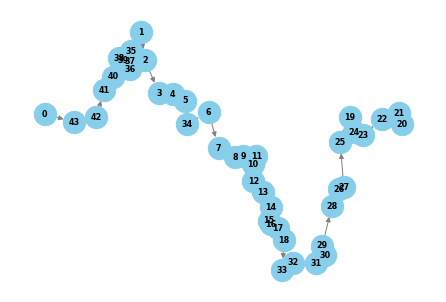

In [13]:
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(nodes_data.apply(lambda row: (
    row["tourist_dest_id"],
    {"pos": (row["x (longitude)"], row["y (latitude)"]), "label": f"{row['Comune']} - {row['Piazza']}"}
), axis=1).tolist())



# Add edges for the optimal path
G.add_edges_from([(origin, destination, {"distance": distance_matrix[origin][destination]}) for origin, destination in solution_path])

# plt.figure(figsize=(15, 15))

# Draw the graph
pos = nx.get_node_attributes(G, "pos")
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color="gray", arrowsize=10)

plt.show()

#  Equivalent Graph

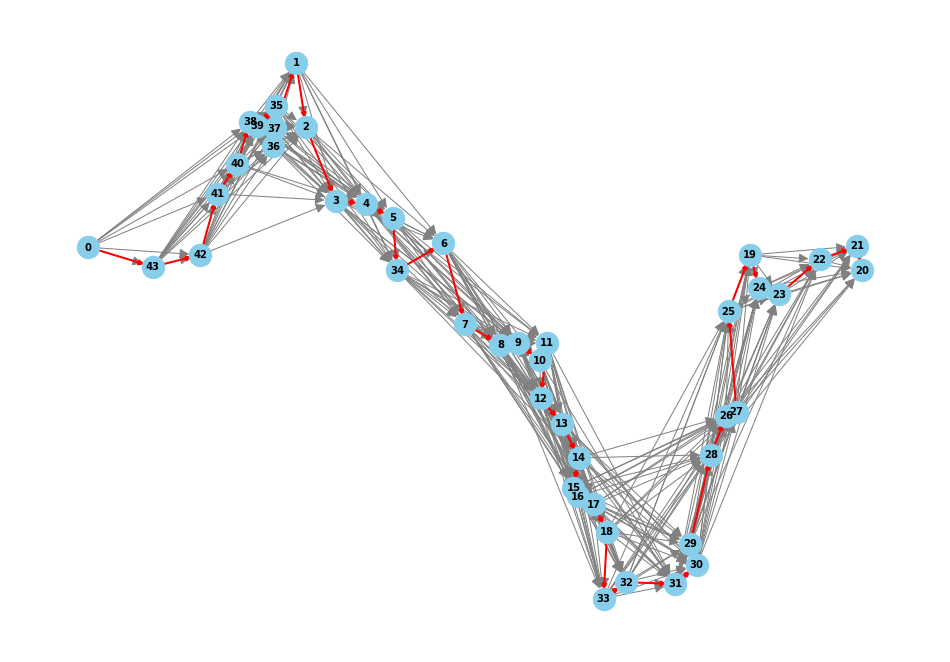

In [14]:
valid_arcs_dict = {}

for i, start_node in enumerate(ordered_path):
    for next_node in ordered_path[i + 1:]:
        distance = nodes_distance(start_node, next_node, ordered_path, distance_matrix)
        if(distance <= max_distance):
            if not G.has_edge(start_node, next_node):
                G.add_edge(start_node, next_node, distance=distance)
                valid_arcs_dict[(start_node, next_node)] = distance
        else: break


# Create a list of edges for the original path
original_path_edges = [(ordered_path[i], ordered_path[i + 1]) for i in range(len(ordered_path) - 1)]

# Visualization
plt.figure(figsize=(13, 9))

# Draw the equivalent graph with all connections
nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color="gray", arrowsize=20)

# Highlight the real path in red
nx.draw_networkx_edges(G, pos, edgelist=original_path_edges, edge_color='red', width=2)

plt.show()

# MIP optimization
Modelling part described in the README

In [15]:

def solve_installation(nodes_data, ordered_path, budget, distance_matrix, max_distance):
    """
    Solve the installation problem with given data.

    Parameters:
    - nodes_data: DataFrame containing information about nodes
    - ordered_path: List representing the order of nodes
    - budget: Total budget for the installation
    - distance_matrix: Matrix containing distances between nodes
    - max_distance: Maximum distance allowed for valid arcs

    Returns:
    - Tuple containing the model, solution, and objective value
    """

    valid_arcs = find_valid_arcs(ordered_path, distance_matrix, max_distance)

    first_node = find_first_node(nodes_data)
    last_node = find_last_node(nodes_data)

    # Create model
    m = mip.Model()

    # define the variables
    y = {(i, j): m.add_var(var_type=mip.BINARY, name=f"y{ordered_path[i]}_{ordered_path[j]}___{i}_{j}") for (i, j) in valid_arcs.keys()}

    #  define the constraints
    # Budget Constraint
    budget += nodes_data.loc[first_node, 'Cost_of_installation []']
    m += mip.xsum(nodes_data.loc[i, 'Cost_of_installation []'] * y[i, j] for (i, j) in valid_arcs.keys()) <= budget

    # Dummy Variable constraint
    z = m.add_var(lb=0.0, var_type=mip.CONTINUOUS, name='max_distance')
    # Now, add a constraint to ensure that z is greater than or equal to each d_ij * y_ij
    for i, j in valid_arcs.keys():
        m += valid_arcs[i, j] - 10**8 * (1 - y[i, j]) <= z

    # Flow Conservation Constraints
    b = {i: 0 for i in nodes_data.index}
    b[first_node] = 1       # Start node (s)
    b[last_node] = -1  # Final node (t)

    for i in nodes_data.index:
        m.add_constr(mip.xsum(y[i, j] for j in nodes_data.index if (i, j) in valid_arcs.keys()) -
                      mip.xsum(y[j, i] for j in nodes_data.index if (j, i) in valid_arcs.keys()) ==
                      b[i])

    # optimize objective function
    m.objective = mip.minimize(z)

    m.optimize()

    if m.status == OptimizationStatus.OPTIMAL:

        y_values = {(i, j): y[i, j].x for (i, j) in valid_arcs.keys()}

        # Identify charging stations and calculate distances
        charging_stations = set()
        distance_between_charging_stations = []

        for (i, j), value in y_values.items():
            if value > 0.5:
                distance_between_charging_stations.append(nodes_distance(i, j, ordered_path, distance_matrix))
                charging_stations.update({i, j})

        # Return a tuple containing model, solution, and objective value
        return m, charging_stations, distance_between_charging_stations, m.objective_value
    else:
        return m, None, None, m.objective_value


In [16]:
def print_solution_problem(budget, first_node, last_node, nodes_data, ordered_path, distance_matrix, objective, m, cs, distance_between_cp):
    first_node = find_first_node(nodes_data)
    last_node = find_last_node(nodes_data)


    if(m.status == OptimizationStatus.OPTIMAL):
        print("---------------- Optimal solution found ----------------")
        print(f"Minimum maximum distance between charging stations: {objective:,.2f} m")
        print(f"Selected charging stations: {cs - {first_node, last_node}}")

        print("Distance between charging stations:", distance_between_cp)
        print(f"Total length path: {nodes_distance(first_node, last_node, ordered_path, distance_matrix):,.10f} m")


        # Calculate budget used
        budget_used = sum(nodes_data.loc[i, 'Cost_of_installation []'] for i in cs if i != first_node and i != last_node)
        print(f"Total budget: {budget:,.0f} €, Budget used: {budget_used:,.0f} €")
        return
    else:
        print("No solution found")

In [17]:
# the budget is set in the previous cells but here it is possible to change it
execution_budget = budget

m, charging_stations, distance_between_cp, objective = solve_installation(nodes_data, ordered_path,
                                                execution_budget, distance_matrix,
                                                max_distance)
print_solution_problem(execution_budget, find_first_node(nodes_data), find_last_node(nodes_data), nodes_data, ordered_path, distance_matrix, objective, m, charging_stations, distance_between_cp)

---------------- Optimal solution found ----------------
Minimum maximum distance between charging stations: 38,228.52 m
Selected charging stations: {32, 2, 34, 42, 11, 25}
Distance between charging stations: [29832.45227, 36050.4827567, 31678.133173999995, 31207.5878, 38124.830018, 38228.51958, 33385.222598]
Total length path: 238,507.2281967000 m
Total budget: 10,000 €, Budget used: 9,506 €


# Equivalent graph with charging point highlighted

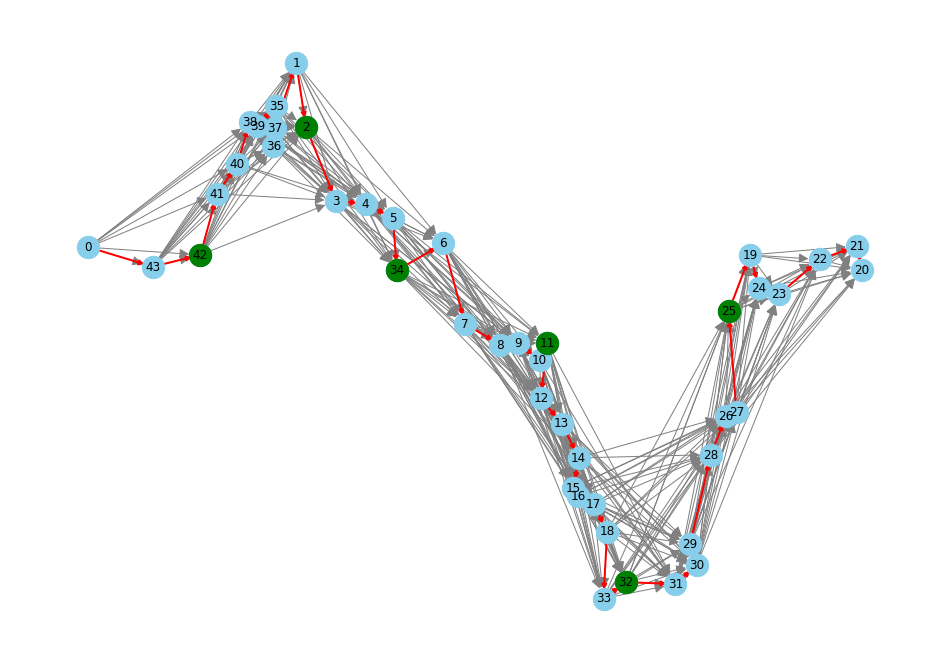

In [18]:
if(m.num_solutions > 0):
    stations = charging_stations - {find_first_node(nodes_data), find_last_node(nodes_data)}
    G = nx.DiGraph()

    # Add nodes
    G.add_nodes_from(nodes_data.apply(lambda row: (
        row["tourist_dest_id"],
        {"pos": (row["x (longitude)"], row["y (latitude)"]), "label": f"{row['Comune']} - {row['Piazza']}"}
    ), axis=1).tolist())

    # rebuild the equivalent graph with all connections
    for i, start_node in enumerate(ordered_path):
        for next_node in ordered_path[i + 1:]:
            distance = nodes_distance(start_node, next_node, ordered_path, distance_matrix)
            if(distance <= max_distance):
                if not G.has_edge(start_node, next_node):
                    G.add_edge(start_node, next_node, distance=distance)
                    valid_arcs_dict[(start_node, next_node)] = distance
            else: break

    # Create a list of edges for the original path
    original_path_edges = [(ordered_path[i], ordered_path[i + 1]) for i in range(len(ordered_path) - 1)]

    # Visualization
    plt.figure(figsize=(13, 9))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', arrowsize=20)

    # Highlight nodes with charging stations
    nx.draw_networkx_nodes(G, pos, nodelist=stations, node_color='green', node_size=500)

    # Highlight the original path in red
    nx.draw_networkx_edges(G, pos, edgelist=original_path_edges, edge_color='red', width=2)

    plt.show()
else:
    print("No solution found")

# Map with charging points and distance between them

In [19]:
def get_coordinates(tourist_dest_id: int) -> tuple[float, float]:
    return nodes_data.loc[tourist_dest_id, 'y (latitude)'], nodes_data.loc[tourist_dest_id, 'x (longitude)']

def create_folium_map(candidate_sites_coordinates: pd.DataFrame, center: list[float]) -> folium.Map:

    # Initialize the map
    map = folium.Map(location=center, zoom_start=10)

    # Add CircleMarkers for each row in candidate_sites_coordinates
    for _, row in candidate_sites_coordinates.iterrows():
        popup_text = f"{row['Comune']} - {row['Piazza']}" if pd.notna(row['Piazza']) else f"{row['Comune']}"
        stations = charging_stations - {find_first_node(nodes_data), find_last_node(nodes_data)}



        # Create markers for charging stations

        if(row['tourist_dest_id'] in stations):
            folium.CircleMarker(
            location=[row['y (latitude)'], row['x (longitude)']],
            radius=12,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=f"id: {row['tourist_dest_id']} real id: {find_id(node_id_mapping, row['tourist_dest_id'])}"
            ).add_to(map)

            # Create text label using DivIcon
            folium.map.Marker(
                [row['y (latitude)'], row['x (longitude)']],
                icon=folium.DivIcon(
                    html=f"""<div style="color: white; font-size: 8pt; font-weight: 900; text-align: center">{row['tourist_dest_id']}</div>"""
                )
            ).add_to(map)
        else:
            folium.CircleMarker(
            location=[row['y (latitude)'], row['x (longitude)']],
            radius=5,
            color='black',
            fill=True,
            fill_color='black',
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=f"id: {row['tourist_dest_id']} real id: {find_id(node_id_mapping, row['tourist_dest_id'])}"
        ).add_to(map)


    charging_stations_ordered = [node for node in ordered_path if node in charging_stations]

    # Draw the segments with alternating colors
    color = "orange"  # Start with green
    for i in range(len(charging_stations_ordered) - 1):
        start_station = charging_stations_ordered[i]
        end_station = charging_stations_ordered[i + 1]
        start_index = ordered_path.index(start_station)
        end_index = ordered_path.index(end_station)

        # Get the sub-path
        sub_path = ordered_path[start_index:end_index + 1]
        sub_path_coords = [get_coordinates(node) for node in sub_path]

        # Draw the sub-path
        folium.PolyLine(sub_path_coords, color=color, weight=5, popup=f'Distance: {nodes_distance(start_station, end_station, ordered_path, distance_matrix):.2f} meters').add_to(map)

        # Alternate the color
        color = "blue" if color == "orange" else "orange"

    return map


# Center location
map_center: list[float] = [45.01896682, 10.29449607]

# Create Folium map with the specified center
nodes_map: folium.Map = create_folium_map(candidate_sites_coordinates=nodes_data, center=map_center)

# Create a Figure and add the Folium map to it
fig: Figure = Figure(width=1000, height=700)
fig.add_child(nodes_map)

# Display the Figure
fig

# 9 different configurations

In [20]:
first_node = find_first_node(nodes_data)
last_node = find_last_node(nodes_data)

b_list = [6_524, 6_525, 10_000, 25_000, 26_000, 28_000, 28_498, 30_000, 100_000]
for b in b_list:
  _, charging_stations, _, objective = solve_installation(nodes_data, ordered_path,
                                            b, distance_matrix,
                                            max_distance)
  if(objective != None):
    print(f"Budget: {b:10,.0f} € | Objective: {objective:10,.8f} m | Charging Stations: {charging_stations - {first_node, last_node}}")
  else:
    print(f"Budget  {b:10,.0f} € | No solution found")

Budget       6,524 € | No solution found
Budget:      6,525 € | Objective: 49,574.26935300 m | Charging Stations: {26, 34, 35, 14}
Budget:     10,000 € | Objective: 38,228.51958001 m | Charging Stations: {32, 2, 34, 42, 11, 25}
Budget:     25,000 € | Objective: 18,119.41949800 m | Charging Stations: {2, 3, 5, 7, 11, 14, 18, 23, 25, 28, 31, 35, 41, 43}
Budget:     26,000 € | Objective: 17,821.99182700 m | Charging Stations: {2, 3, 5, 7, 11, 14, 23, 25, 28, 31, 33, 37, 39, 42, 43}
Budget:     28,000 € | Objective: 16,911.60298200 m | Charging Stations: {2, 3, 5, 6, 9, 13, 17, 23, 25, 26, 30, 32, 37, 39, 42, 43}
Budget:     28,498 € | Objective: 16,011.18979000 m | Charging Stations: {2, 3, 5, 6, 9, 13, 17, 19, 22, 25, 28, 30, 32, 37, 39, 42, 43}
Budget:     30,000 € | Objective: 16,011.18979000 m | Charging Stations: {2, 3, 5, 6, 9, 13, 16, 19, 22, 25, 28, 30, 31, 33, 37, 39, 42, 43}
Budget:    100,000 € | Objective: 16,011.18979000 m | Charging Stations: {2, 3, 5, 6, 8, 11, 12, 15, 17, 

In [21]:
budget_value = 10_000
max_distance = 50_000
m, charging_stations, _, objective = solve_installation(nodes_data, ordered_path,
                                            budget_value, distance_matrix,
                                            max_distance)
print(f"Budget: {budget_value:,.0f} €")
print(f"Solution: {charging_stations}")
print(f"Objective: {objective:10,.8f} m")

print("After increasing budget by 10%")
budget_value_2 = budget_value * 1.1

m2, charging_stations2, _, objective2 = solve_installation(nodes_data, ordered_path,
                                            budget_value_2, distance_matrix,
                                            max_distance)
print(f"Budget: {budget_value_2:,.0f} €")
print("Solution:", charging_stations2)
print(f"Objective: {objective2:10,.10f} m, Decrease: {(abs(objective2 - objective) / objective) * 100: 6.2f}%")

Budget: 10,000 €
Solution: {0, 32, 2, 34, 42, 11, 20, 25}
Objective: 38,228.51958001 m
After increasing budget by 10%
Budget: 11,000 €
Solution: {0, 2, 34, 8, 41, 16, 20, 25, 29}
Objective: 34,777.8554809988 m, Decrease:   9.03%


# Minimum budget to get a feasible problem

In [22]:
def find_lowest_feasible_budget_recursive(low, high):
    if low >= high:
        m,_,_,distance = solve_installation(nodes_data, ordered_path, low, distance_matrix, max_distance)
        return (low, distance) if m.status == OptimizationStatus.OPTIMAL else None

    mid = (low + high) // 2
    m,_,_,objective = solve_installation(nodes_data, ordered_path, mid, distance_matrix, max_distance)

    if m.status == OptimizationStatus.INFEASIBLE:  # Infeasible at this budget, go higher
        return find_lowest_feasible_budget_recursive(mid + 1, high)
    else:  # Feasible at this budget, try to find a lower feasible budget
        return find_lowest_feasible_budget_recursive(low, mid)


# Initialize with the first known feasible budget and distance
initial_budget, initial_distance = find_lowest_feasible_budget_recursive(0, 10000)
if initial_distance is not None:
        print(f"The lowest feasible budget is: {initial_budget:,.0f} € with a distance of {initial_distance:,.10f} m")
else:
        print("Unable to find a feasible budget within the given range.")

The lowest feasible budget is: 6,525 € with a distance of 49,574.2693530023 m


# Parametric Analysis with a granularity of 500€

In [23]:
solutions = []
first_node = find_first_node(nodes_data)
last_node = find_last_node(nodes_data)

# Reverse mapping to map new IDs back to original IDs
reverse_node_id_mapping = {i: node_id for node_id, i in node_id_mapping.items()}

def unmap_charging_stations(charging_stations, reverse_mapping):
    return {reverse_mapping[node] for node in charging_stations}

def print_results_table(results, reverse_mapping=None):
    # Create a table with headers
    table = PrettyTable()
    table.field_names = ["Budget (€)", "Charging Stations", "Distance (m)"]

    # Fill the table with data
    for budget, distance, stations in results:
        if reverse_mapping:
            # Unmap charging stations
            stations = unmap_charging_stations(stations, reverse_mapping)
        # Convert set of charging stations to a string
        stations_str = ', '.join(str(node) for node in stations)
        # Add row to the table
        table.add_row([f"{budget:,.0f} €", f"{stations_str}", f"{distance:,.2f} m"])

    print(table)

budget_value2 = initial_budget
results = []
while budget_value2 < 30_000:
  m2, charging_stations2,_,objective2 = solve_installation(nodes_data, ordered_path,
                                            budget_value2, distance_matrix,
                                            max_distance)
  charging_stations2 = charging_stations2 - {first_node, last_node}
  solutions.append((budget_value2, objective2, charging_stations2))
  budget_value2 += 500

print_results_table(solutions)

+------------+---------------------------------------------------------------+--------------+
| Budget (€) |                       Charging Stations                       | Distance (m) |
+------------+---------------------------------------------------------------+--------------+
|  6,525 €   |                         26, 34, 35, 14                        | 49,574.27 m  |
|  7,025 €   |                         26, 34, 35, 14                        | 49,574.27 m  |
|  7,525 €   |                         34, 35, 28, 14                        | 49,574.27 m  |
|  8,025 €   |                        4, 39, 8, 18, 26                       | 44,815.59 m  |
|  8,525 €   |                        3, 40, 8, 18, 26                       | 43,185.92 m  |
|  9,025 €   |                        3, 40, 8, 18, 27                       | 41,551.89 m  |
|  9,525 €   |                     32, 2, 34, 42, 11, 25                     | 38,228.52 m  |
|  10,025 €  |                     32, 2, 34, 41, 11, 25    

In [24]:
print_results_table(solutions, reverse_mapping=reverse_node_id_mapping)

+------------+--------------------------------------------------------------------+--------------+
| Budget (€) |                         Charging Stations                          | Distance (m) |
+------------+--------------------------------------------------------------------+--------------+
|  6,525 €   |                           82, 77, 61, 36                           | 49,574.27 m  |
|  7,025 €   |                           82, 77, 61, 36                           | 49,574.27 m  |
|  7,525 €   |                           82, 36, 77, 63                           | 49,574.27 m  |
|  8,025 €   |                         41, 61, 21, 86, 29                         | 44,815.59 m  |
|  8,525 €   |                         41, 29, 20, 87, 61                         | 43,185.92 m  |
|  9,025 €   |                         41, 20, 87, 29, 62                         | 41,551.89 m  |
|  9,525 €   |                       32, 68, 77, 18, 89, 60                       | 38,228.52 m  |
|  10,025 

In [25]:
ending_time = datetime.datetime.now()
print(f"Notebook execution time: {ending_time - starting_time}")

Notebook execution time: 0:02:37.778055
